In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from roboflow import Roboflow
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import os

## Data Exploration

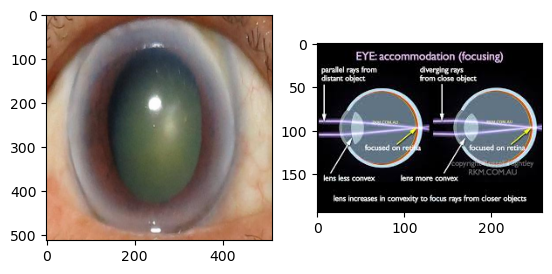

In [2]:
cataract = os.path.join(
    "Datasets/raw dataset/Cataract",
    random.choice(os.listdir("Datasets/raw dataset/Cataract")))
normal = os.path.join("Datasets/raw dataset/Normal",
                      random.choice(os.listdir("Datasets/raw dataset/Normal")))
fig, ax = plt.subplots(1, 2)

ax[0].imshow(cv2.cvtColor(cv2.imread(cataract), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(cv2.imread(normal), cv2.COLOR_BGR2RGB))

## Pre-Processing

In [3]:
rf = Roboflow(api_key="dHg9mKRRDSCBTlbaEl8w")
project_eye = rf.workspace().project("eyes-dpurk")
model_eye = project_eye.version(2).model
project_iris = rf.workspace().project("iris_120_set")
model_iris = project_iris.version(7).model

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


In [4]:
def extract_eye(img):
    eye_predictions = model_eye.predict(img, confidence=20,
                                        overlap=40).json()['predictions']
    eyes = []
    if eye_predictions != []:
        for prediction in eye_predictions:
            if prediction["class"] == "Open Eyes":
                X, Y, W, H = int(prediction['x']), int(prediction['y']), int(
                    prediction['width']), int(prediction['height'])

                H = int(H / 2)
                W = int(W / 2)

                cropped_image = img[Y - H:Y + H, X - W:X + W]
                eyes.append(cropped_image)

    return eyes

In [5]:
def extract_iris(img):
    predictions_iris = model_iris.predict(img, confidence=40,
                                          overlap=40).json()['predictions']
    iris = None
    if predictions_iris != []:
        for prediction in predictions_iris:
            if prediction["class"] == "0":
                flag = False
                X, Y, W, H = int(prediction['x']), int(prediction['y']), int(
                    prediction['width']), int(prediction['height'])

                H = int(H / 2)
                W = int(W / 2)

                iris = img[Y - H:Y + H, X - W:X + W]

    return iris

IndexError: list index out of range

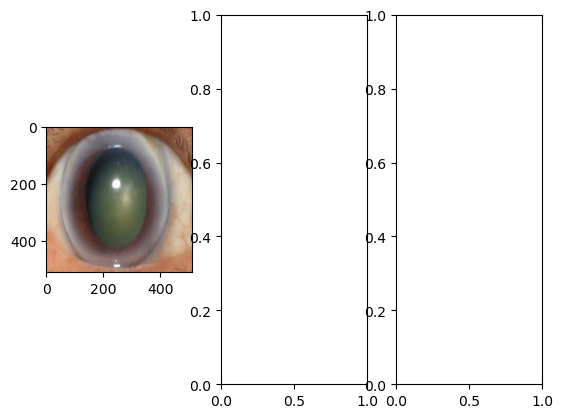

In [6]:
fig, ax = plt.subplots(1, 3)
img = cv2.imread(cataract)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(img)
eye = extract_eye(img)[0]
ax[1].imshow(eye)
iris = extract_iris(eye)
ax[2].imshow(iris)

In [7]:
def process_cataract():
    input_directory = "Datasets/raw dataset/Cataract/"
    output_directory = "Datasets/train/Cataract_iris/"
    for filename in os.listdir(input_directory):
        img = os.path.join(input_directory, filename)
        output_filename = f"{count}.jpg"
        count += 1
        # checking if it is a file
        if os.path.isfile(img):
            img = cv2.imread(img)
            try:
                eyes = extract_eye(img)
            except:
                cv2.imwrite(os.path.join(output_directory, output_filename),
                            img)
                continue

            for eye in eyes:
                try:
                    iris = extract_iris(eye)
                    cv2.imwrite(os.path.join(output_directory, output_filename),
                                iris)
                except:
                    cv2.imwrite(os.path.join(output_directory, output_filename),
                                eye)
                    continue
    print("Cataract Eye Image Pre-Processing Complete!")

In [8]:
def process_normal():
    input_directory = "Datasets/raw dataset/Normal/"
    output_directory = "Datasets/train/Normal_iris/"
    count = 0

    for filename in os.listdir(input_directory):
        img = os.path.join(input_directory, filename)
        output_filename = f"{count}.jpg"
        count += 1
        # checking if it is a file
        if os.path.isfile(img):
            img = cv2.imread(img)
            try:
                eyes = extract_eye(img)
            except:
                continue

            for eye in eyes:
                try:
                    iris = extract_iris(eye)
                    cv2.imwrite(os.path.join(output_directory, output_filename),
                                iris)
                except:
                    continue
    print("Normal Eye Image Pre-Processing Complete!")

## Splitting Up Dataset

In [10]:
height, width = 120, 120
training_batch_size = 32

In [11]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets/train",
    validation_split=0.2,
    subset="training",
    seed=21,
    image_size=(height, width),
    batch_size=training_batch_size)

Found 2603 files belonging to 2 classes.
Using 2083 files for training.


In [12]:
image_cat = train_set.class_names
print(image_cat)

['Cataract_iris', 'Normal_iris']


In [13]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets/train",
    validation_split=0.2,
    subset="validation",
    seed=21,
    image_size=(height, width),
    batch_size=training_batch_size)

Found 2603 files belonging to 2 classes.
Using 520 files for validation.


## Training ResNet50

In [13]:
dnn_model = keras.Sequential()

In [14]:
imported_model = tf.keras.applications.ResNet50(include_top=False,
                                                input_shape=(height, width, 3),
                                                pooling='avg',
                                                classes=2,
                                                weights='imagenet')
for layer in imported_model.layers:
    layer.trainable = False

In [15]:
dnn_model.add(imported_model)
# dnn_model.add(Dense(1024, activation="relu"))

# dnn_model.add(Dense(512, activation="relu"))
dnn_model.add(Dense(128, activation="relu"))
dnn_model.add(Dense(64, activation="relu"))
dnn_model.add(Dense(1, activation='sigmoid'))

In [16]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 128)              262272    
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 64)               8256      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 1)                65        
 pper)                                                           
                                                                 
Total params: 23,858,305
Trainable params: 270,593
Non-trainable params: 23,587,712
______________________________________

In [17]:
dnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [37]:
history = dnn_model.fit(train_set, validation_data=validation_set, epochs=10)

Epoch 1/10


2023-04-07 20:41:14.931511: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-07 20:41:14.931831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9342

2023-04-07 20:41:19.886353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 7s 93ms/step - loss: 0.1583 - accuracy: 0.9342 - val_loss: 0.1056 - val_accuracy: 0.9558
Epoch 2/10
66/66 [==============================] - 4s 64ms/step - loss: 0.0540 - accuracy: 0.9822 - val_loss: 0.0942 - val_accuracy: 0.9654
Epoch 3/10
66/66 [==============================] - 4s 65ms/step - loss: 0.0411 - accuracy: 0.9837 - val_loss: 0.0887 - val_accuracy: 0.9654
Epoch 4/10
66/66 [==============================] - 4s 65ms/step - loss: 0.0217 - accuracy: 0.9918 - val_loss: 0.0679 - val_accuracy: 0.9788
Epoch 5/10
66/66 [==============================] - 4s 65ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.1967 - val_accuracy: 0.9385
Epoch 6/10
66/66 [==============================] - 4s 65ms/step - loss: 0.0258 - accuracy: 0.9904 - val_loss: 0.1329 - val_accuracy: 0.9654
Epoch 7/10
66/66 [==============================] - 4s 65ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0993 - val_accuracy: 0.9769
Epoch 8/10
66/66 [======

In [7]:
def predict(img, model):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    eyes = extract_eye(img)
    for eye in eyes:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(eye)
        iris = extract_iris(eye)
        ax[1].imshow(iris)
        image_resized = cv2.resize(iris, (height, width))
        image = np.expand_dims(image_resized, axis=0)
        model_pred = model.predict(image)[0][0]
        if model_pred < 0.5:
            print(
                "Sorry to tell you that your eye might affected with Cataract !"
            )
            fig.suptitle(
                'Sorry to tell you that your eye might affected with Cataract !',
                fontsize=12)
        else:
            print("Hurrey! You Have Normal Eye.")
            fig.suptitle('Hurrey! You Have Normal Eye.', fontsize=12)

        print(model_pred)

In [79]:
resnet_test = keras.models.load_model(os.path.join("Model/Resnet/", "Best"))

Hurrey! You Have Normal Eye.
0.91630316
Hurrey! You Have Normal Eye.
0.89125973


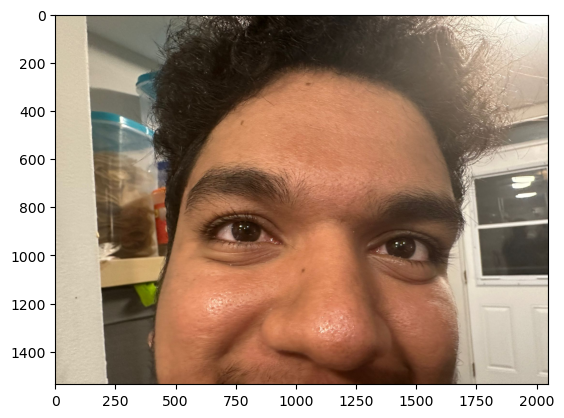

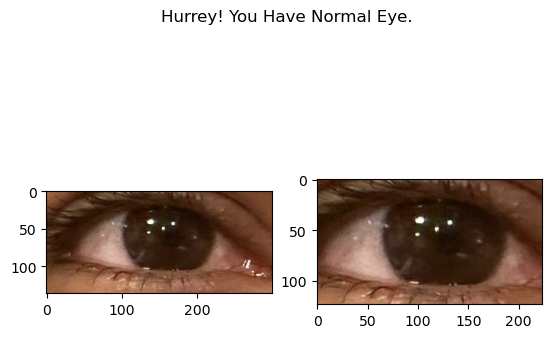

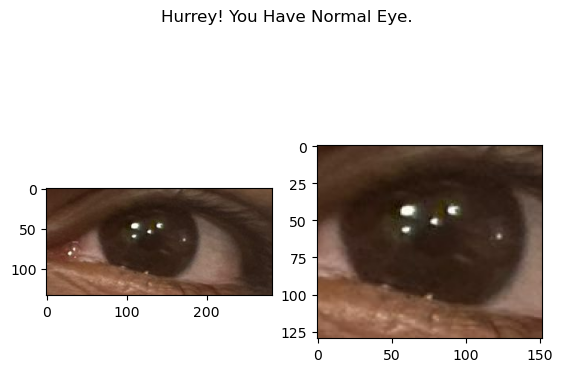

In [42]:
testing = "Datasets/Unseen/"
img = os.path.join(testing, random.choice(os.listdir(testing)))
predict("Datasets/Unseen/7.jpeg", resnet_test)

In [43]:
# dnn_model.save(os.path.join("Model/Resnet/", "Best"))

2023-04-07 20:44:43.112237: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Model/Resnet/Best/assets


INFO:tensorflow:Assets written to: Model/Resnet/Best/assets


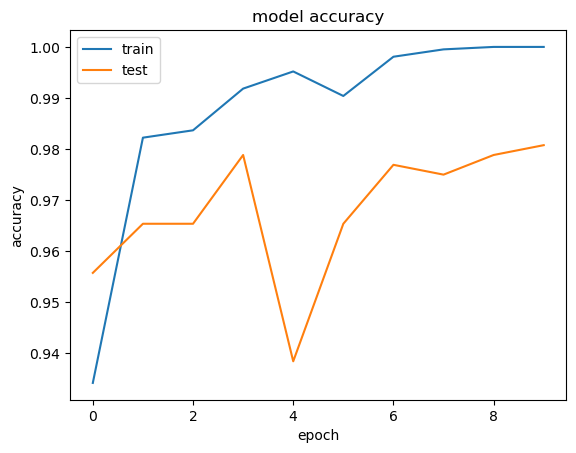

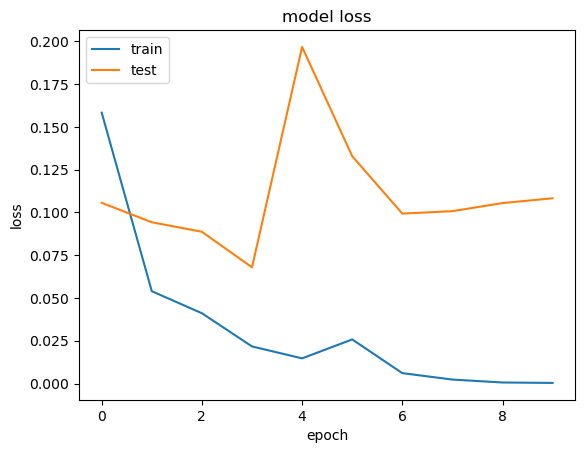

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Efficient Net

In [14]:
Efficientnet_model_directory = "Model/Efficientnet/"

In [15]:
efficient_net7 = tf.keras.applications.EfficientNetB7(include_top=False,
                                                      input_shape=(height,
                                                                   width, 3),
                                                      pooling='avg',
                                                      classes=2,
                                                      weights='imagenet')

efficientnet = keras.Sequential()
efficientnet.add(efficient_net7)
efficientnet.add(Dense(units=128, activation='relu'))
efficientnet.add(Dense(units=64, activation='relu'))
efficientnet.add(Dense(units=32, activation='relu'))
efficientnet.add(Dense(units=1, activation='sigmoid'))
efficientnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 module_wrapper (ModuleWrapp  (None, 128)              327808    
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 64)               8256      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 32)               2080      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 1)                33        
 pper)                                                  

In [16]:
efficientnet.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [19]:
history = efficientnet.fit(train_set, validation_data=validation_set, epochs=10)

Epoch 1/10
66/66 [==============================] - 58s 827ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0737 - val_accuracy: 0.9808
Epoch 2/10


KeyboardInterrupt: 

Sorry to tell you that your eye might affected with Cataract !
0.00044542854


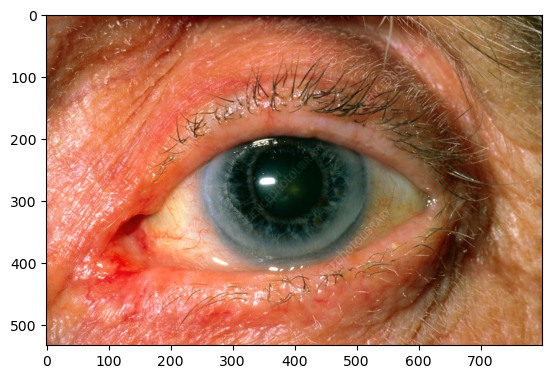

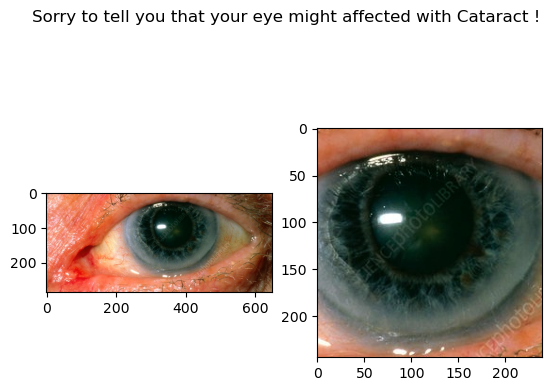

In [31]:
testing = "Datasets/Unseen/"
img = os.path.join(testing, random.choice(os.listdir(testing)))
predict("Datasets/Unseen/17.jpeg", efficientnet)

In [26]:
efficientnet.save(os.path.join(Efficientnet_model_directory, "Best"))

2023-04-08 16:40:46.021396: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Model/Efficientnet/Best/assets


INFO:tensorflow:Assets written to: Model/Efficientnet/Best/assets


## Results Comparison

In [32]:
resnet_test = keras.models.load_model(os.path.join("Model/Resnet/", "Best"))

In [8]:
efficientnet_test = keras.models.load_model(
    os.path.join("Model/Efficientnet/", "Best"))

Metal device set to: Apple M1 Pro


2023-04-10 18:18:04.852006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-10 18:18:04.852307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Hurrey! You Have Normal Eye.
0.9958121
Hurrey! You Have Normal Eye.
0.9284311


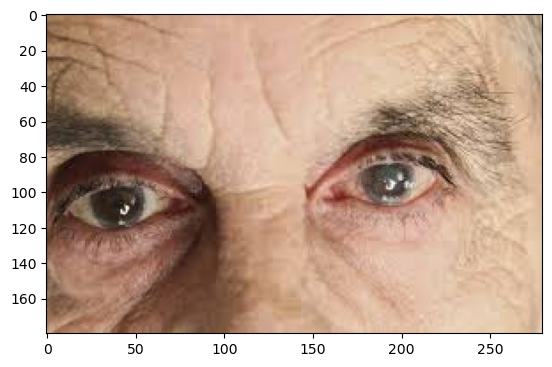

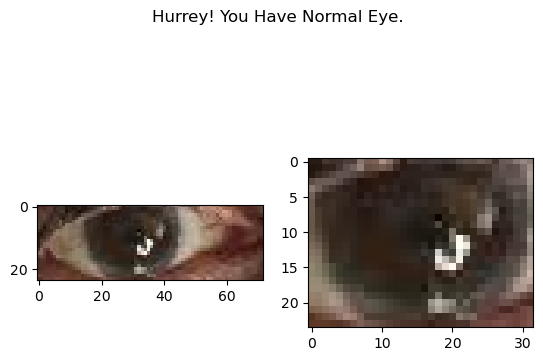

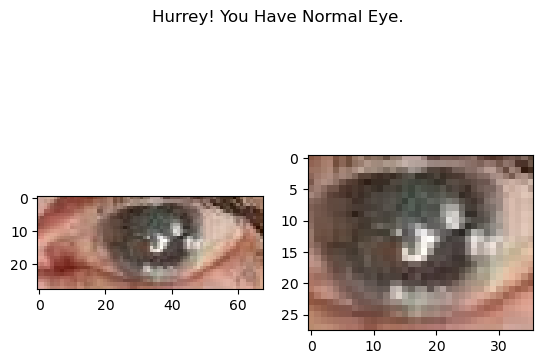

In [38]:
predict("Datasets/Unseen/12.jpeg", resnet_test)

2023-04-10 18:19:09.435669: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-10 18:19:11.129499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Hurrey! You Have Normal Eye.
0.9946648
Hurrey! You Have Normal Eye.
0.99761534


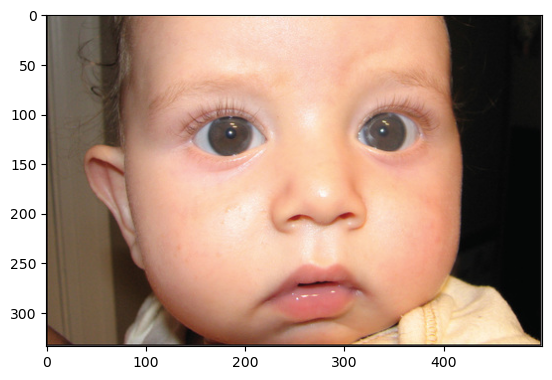

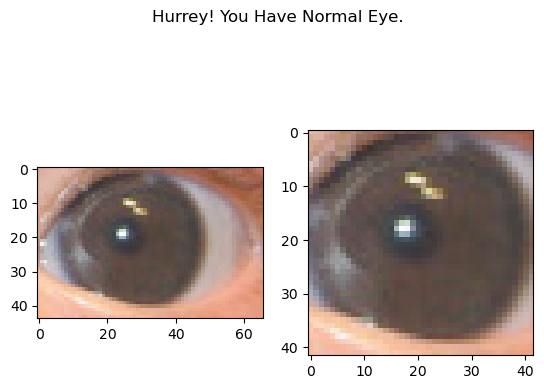

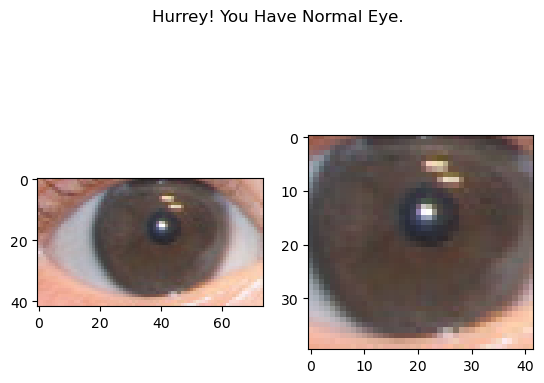

In [14]:
predict("Datasets/Unseen/24.jpg", efficientnet_test)